In [ ]:
!pip3 install textblob --quiet


You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-480d7415-fffa-4673-8ce6-162ff70e6817/bin/python -m pip install --upgrade pip' command.


Note: Install graphframes library before running

#### DATA:

  DATA COLUMNS:
  1. marketplace       - 2 letter country code of the marketplace where the review was written.
  2. customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
  3. review_id         - The unique ID of the review.
  4. product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
                      for the same product in different countries can be grouped by the same product_id.
  5. product_parent    - Random identifier that can be used to aggregate reviews for the same product.
  6. product_title     - Title of the product.
  7. product_category  - Broad product category that can be used to group reviews 
                      (also used to group the dataset into coherent parts).
  8. star_rating       - The 1-5 star rating of the review.
  9. helpful_votes     - Number of helpful votes.
  10. total_votes       - Number of total votes the review received.
  11. vine              - Review was written as part of the Vine program.
  12. verified_purchase - The review is on a verified purchase.
  13. review_headline   - The title of the review.
  14. review_body       - The review text.
  15. review_date       - The date the review was written.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType,FloatType

#for pagerank
from graphframes import GraphFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#for NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Loading data

#### Loading watches reviews

In [ ]:
# File location 
file_location = "/FileStore/tables/amazon_reviews_us_Watches_v1_00.tsv"
df_watches_review = spark.read.format('csv') \
      .option('header', 'true') \
      .option('delimiter', '\t') \
      .option('inferSchema', 'true') \
      .load(file_location)

In [ ]:
# limiting watches review, to add other category reviews
df_watches_review_limited = df_watches_review.limit(500000)

#### Loading personal care reviews

In [ ]:
file_location = "/FileStore/tables/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv"

df_personal_care_review = spark.read.format('csv') \
      .option('header', 'true') \
      .option('delimiter', '\t') \
      .option('inferSchema', 'true') \
      .load(file_location)


In [ ]:
df_personal_care_review.count()

Out[6]: 85981

#### Loading gift card reviews

In [ ]:

file_location = "/FileStore/tables/amazon_reviews_us_Gift_Card_v1_00.tsv"

df_gift_card_review = spark.read.format('csv') \
      .option('header', 'true') \
      .option('delimiter', '\t') \
      .option('inferSchema', 'true') \
      .load(file_location)

In [ ]:
df_gift_card_review.count()

Out[8]: 149086

In [ ]:
# union all three categories
df_review_unioned = df_watches_review_limited.union(df_personal_care_review)
df_reviews_for_all_category = df_review_unioned.union(df_gift_card_review)

In [ ]:
print("The final count on the dataset is {}".format(df_reviews_for_all_category.count()))

The final count on the dataset is 735067


##### adding sentiment column from star_rating

In [ ]:
def sentiment(rating_series):
    def classify(rating):
        if rating == 3.0:
            return "Neutral"
        elif rating == 1.0 or rating == 2.0:
            return "Negative"
        elif rating >= 4.0:
            return "Positive"
    
    return rating_series.apply(classify)

finding_sentiment_pandas_udf = pandas_udf(sentiment, returnType=StringType())
df_reviews_for_all_category = df_reviews_for_all_category.withColumn("sentiment",finding_sentiment_pandas_udf(F.col('star_rating')))

In [ ]:
display(df_reviews_for_all_category.limit(10))

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold Ion-Plated Stainless Steel and Brown Leather Watch",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments almost every time I wear it. Dainty.,2015-08-31,Positive
US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic Silver Automatic Mesh Bracelet Analog Watch,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31,Positive
US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Watch Band Strap Pebble Time/Pebble Classic,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31,Negative
US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless Steel Watch with Green Canvas Band,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper prices in other places after making the purchase",2015-08-31,Positive
US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stainless Steel Black Dial Mechanical Watch,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links","Beautiful watch face. The band looks nice all around. The links do make that squeaky cheapo noise when you swing it back and forth on your wrist which can be embarrassing in front of watch enthusiasts. However, to the naked eye from afar, you can't tell the links are cheap or folded because it is well polished and brushed and the folds are pretty tight for the most part.I love the new member of my collection and it looks great. I've had it for about a week and so far it has kept good time despite day 1 which is typical of a new mechanical watch",2015-08-31,Positive
US,6576411,RA51CP8TR5A2L,B00EYSOSE8,230493695,Casio Men's GW-9400BJ-1JF G-Shock Master of G Rangeman Digital Solar Black Carbon Fiber Insert Watch,Watches,5,0,0,N,Y,No complaints,"i love this watch for my purpose, about the people complaining should of done their research better before buying. dumb people.",2015-08-31,Positive
US,11811565,RB2Q7DLDN6TH6,B00WM0QA3M,549298279,Fossil Women's ES3851 Urban Traveler Multifunction Stainless Steel Watch - Rose,Watches,5,1,1,N,Y,Five Stars,"for my wife and she loved it, looks great and a great price!",2015-08-31,Positive
US,49401598,R2RHFJV0UYBK3Y,B00A4EYBR0,844009113,INFANTRY Mens Night Vision Analog Quartz Wrist Watch with Nato Nylon Watchband-Red.,Watches,1,1,5,N,N,I was about to buy this thinking it was a ...,I was about to buy this thinking it was a Swiss Army Infantry watch-- the description uses the words infantry and army--- when I realized it must be a fraud for $12.00. This should not be offered on Amazon-- it is designed to confuse consumers.,2015-08-31,Negative
US,45925069,R2Z6JOQ94LFHEP,B00MAMPGGE,263720892,G-Shock Men's Grey Sport Watch,Watches,5,1,2,N,Y,Perfect watch!,"Watch is perfect. Rugged with the metal ""Bull Bars"". The red accents are a great touch and I get compliments when wearing it. If you are worried about being able to read this in sunlight or in the dark don't! The LED ilumination works great! I might even get this in a different color for my next G-Shock purchase!",2015-08-31,Positive
US,44751341,RX27XIIWY5JPB,B004LBPB7Q,124278407,Heiden Quad Watch Winder in Black Leather,Watches,4,0,0,N,Y,Great quality and build,Great quality and build.The motors are really silent.After fiddling with the settings my watches are always charged and ready to use.,2015-08-31,Positive


### 1. Data Cleaning

1. Filtering unneccesary columns

In [ ]:
df_reviews_for_all_category = df_reviews_for_all_category.drop("marketplace","vine","verified_purchase")

2. Identifying null values in the dataset

In [ ]:
display(df_reviews_for_all_category.describe())

summary,customer_id,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
count,735067,735067,735067,735067,735067,735067,735067,735067,735067,735067,735066,734874
mean,2.4617038395131327E7,null,6.951533350865672E9,5283771.0,null,4.255745394637495,0.8937539027054676,1.1540009278065808,null,null,3.133371810553613E20,1.7352937108333334E8
stddev,1.6295943833258342E7,null,2.6461016275601945E9,3522514.0,null,1.2598076052543696,11.856160077985736,12.994632861148018,null,null,1.7162176226621113E21,8.501167788126925E8
min,10016,R1000TMU4SGH73,097459363X,"""ABC Products"" - Multi Shape ~ Pill Cutter (Cuts Any Shape Pill - Has Shielded Blade for Safety)***",Gift Card,1,0,0,N,N,,"It's cheaper than Japan,cool!"
max,53096566,RZZZUXPPRY4T1,BT00DDZD6G,"ÒTop GunÓ Large Aviator Bifocal Sunglasses for Youthful, Active Men and Women",Watches,5,5987,6323,Y,Y,😰👇,🙌🙌🙌👍👍👍


1. drop null values from review_body
2. drop strings with emoji's

In [ ]:
df_removed_nulls = df_reviews_for_all_category.na.drop(subset=["review_body","review_headline"])

In [ ]:
# Regular expression to match emojis
emoji_pattern = u"[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F910-\U0001F96C\U0001F980-\U0001F9E0]+"

# Filter strings that doesnot contain emojis
df_reviews_final = df_removed_nulls.filter(F.regexp_extract("review_body", emoji_pattern, 0) == "")


#### Dataset after cleaning

##### 1. Reviews by sentiment on Each category

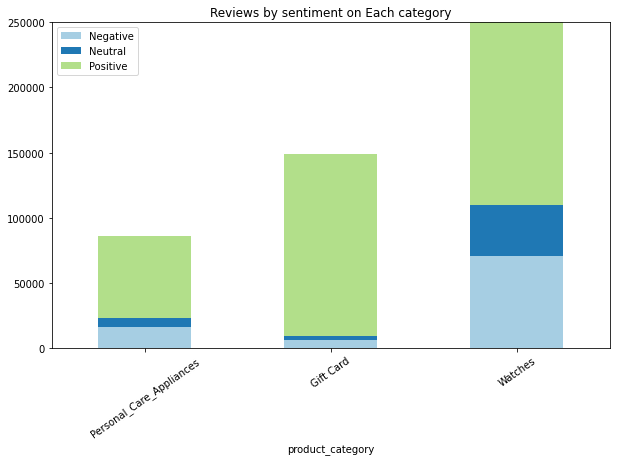

In [ ]:
rating_counts = df_reviews_final.groupBy('sentiment','product_category').agg(F.count('*').alias('rating_count'))

# Pivoting the sentiment column to create separate columns for each sentiment
pivoted_df = rating_counts.groupBy('product_category')\
                     .pivot('sentiment', ['Negative', 'Neutral', 'Positive'])\
                     .sum('rating_count')\
                     .fillna(0)

# Converting the pivoted DataFrame to Pandas
pandas_df = pivoted_df.toPandas()

# Create a stacked bar plot of the counts
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim(0, 250000)
ax.set_title("Reviews by sentiment on Each category")
colors = sns.color_palette('Paired')
pandas_df.plot(kind='bar', stacked=True, x='product_category',color=colors,ax=ax)
ax.set_xticklabels(pandas_df['product_category'],rotation=35);

##### 2. Volume of data in each category

In [ ]:
df_grouped = df_reviews_final.groupby("product_category").agg(F.count("*").alias("count"))
display(df_grouped)

product_category,count
Watches,498136
Personal_Care_Appliances,85915
Gift Card,148885


Databricks visualization. Run in Databricks to view.

##### 3. Distinct products in each category

In [ ]:
df_popular_products = df_reviews_final.groupby("product_category").agg(F.countDistinct("product_id").alias("count"))
display(df_popular_products)

product_category,count
Personal_Care_Appliances,17557
Gift Card,1779
Watches,91266


Databricks visualization. Run in Databricks to view.

### 2. Analysis on review's dataset

#### 1. Rating volume by customers

In [ ]:
rating_vol = df_reviews_final.groupBy('customer_id').count().orderBy('count',ascending=False)
display(rating_vol)

customer_id,count
19619134,121
42418272,89
13355404,87
42416004,85
44191290,69
5072809,67
22962882,66
47769852,60
21375608,59
1389173,58


Databricks visualization. Run in Databricks to view.

Customers always showed their interest in reviewing the product with a higher rating of 121 reviews with lower rating of 13 reviews

so, it is always a good start to use customer reviews to suggest similar products

##### 1a. Sentiment Trend over time

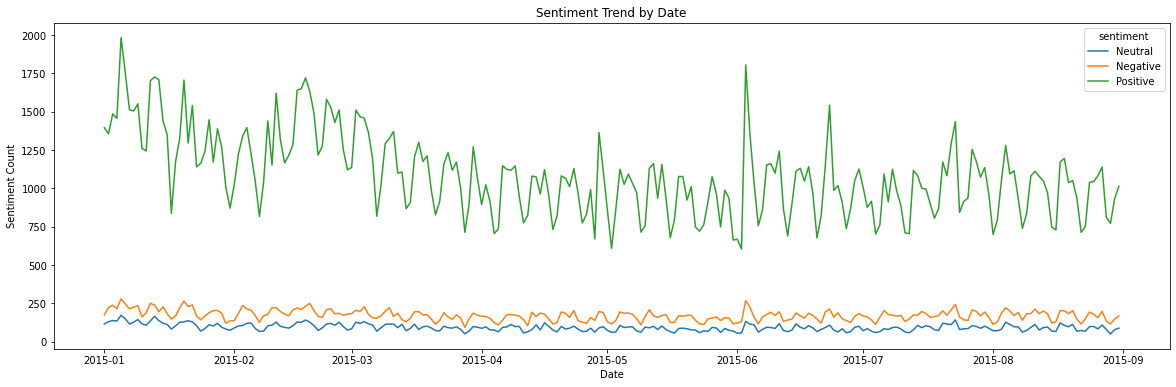

In [ ]:
review_df = df_reviews_final.select(F.col("review_date"), F.col("review_body"),F.col("sentiment")).filter(F.year(F.col("review_date")) == 2015)
sentiment_trend_df = review_df.groupBy("review_date", "sentiment").agg(F.count("*").alias("sentiment_count"))

fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(x="review_date", y="sentiment_count", hue="sentiment", data=sentiment_trend_df.toPandas())
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment Count")
ax.set_title("Sentiment Trend by Date")
plt.show()


1. Positive review count from fluctuates highly during holiday's season like (january, june).
2. Negative/ neutral reviews remains constant throught the year.

#### 2. Identifying User Characteristics

In [ ]:
# grouping customer_id
grouped_customer = df_reviews_final.groupBy('customer_id','sentiment')

# categorizing users based on their reviewing frequency
reviews_per_user = grouped_customer.count().orderBy('count', ascending=False)

regular_users = reviews_per_user.filter(F.col('count') > 50).select('customer_id').distinct()
medium_users = reviews_per_user.filter((F.col('count') <= 50) & (F.col('count') > 20)).select('customer_id').distinct()

In [ ]:
def visualize_user_behaviour(input_df,title,size):
    
    # Pivoting the sentiment column to create separate columns for each sentiment
    pivoted_df = input_df.groupBy('customer_id')\
                     .pivot('sentiment', ['Negative', 'Neutral', 'Positive'])\
                     .sum('count')\
                     .fillna(0)
    # Converting the pivoted DataFrame to Pandas
    pandas_df = pivoted_df.toPandas()
    # Create a stacked bar plot of the counts
    fig, ax = plt.subplots(figsize= size)
    colors = sns.color_palette('Dark2')
    pandas_df.plot(kind='bar', stacked=True, x='customer_id',color=colors,ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(pandas_df['customer_id'],rotation=35);

##### 2a. Behaviour of frequently visiting customers

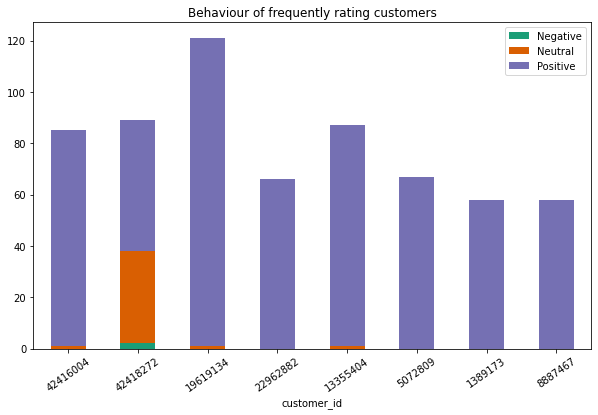

In [ ]:
regular_user_behaviour = reviews_per_user.join(regular_users, on='customer_id', how='inner')
visualize_user_behaviour(regular_user_behaviour,title = "Behaviour of frequently rating customers",size=(10,6))


##### 2b. Behaviour of occasionally visiting customers

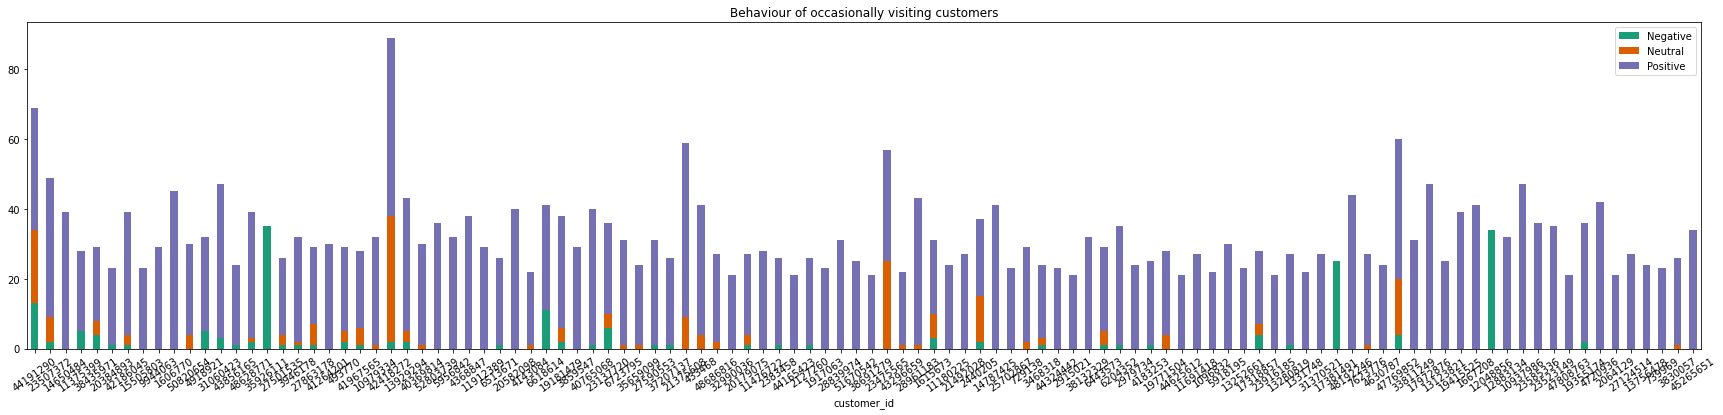

In [ ]:
medium_user_behaviour = reviews_per_user.join(medium_users, on='customer_id', how='inner')
visualize_user_behaviour(medium_user_behaviour,title = "Behaviour of occasionally visiting customers",size=(30,6))

##### 2c. Highly bought products by frequent customers

In [ ]:
# frequent customers
ratings_per_user = df_reviews_final.groupBy('customer_id').count().filter(F.col('count')>30)

# Joining ratings_per_user with df_reviews_final on customer_id column
frequent_ratings = ratings_per_user.join(df_reviews_final, on='customer_id', how='inner')

# Group by product_id to get count of ratings for each product by frequent customers
frequent_products = frequent_ratings.groupBy('product_title','product_category').agg({'count': 'sum'}).withColumnRenamed('sum(count)', 'frequent_ratings_count').filter(F.col('frequent_ratings_count') > 30).orderBy("frequent_ratings_count",ascending=False).limit(10)

display(frequent_products)

product_title,product_category,frequent_ratings_count
Clockwork Synergy Classic Nylon Nato watch straps bands,Watches,1319
amjimshop Vovotrade(TM) unisex Digital LED Touch Sports Silicone Bracelet Wrist Watch,Watches,726
Yodee Unisex Touchscreen Red LED Digital Bright Color Rubber Band Wrist Watch (Assorted Colors) 30% Off,Watches,484
U.S. Polo Assn. Sport Men's US9061 Watch with Black Rubber Strap Watch,Watches,381
Unisex Touch Digital Red Led Silicone Sports Wrist Watch Watch Orange,Watches,242
Unisex Touch Digital Red Led Silicone Sports Wrist Watch Watch Grey,Watches,242
URgreat Unisex Magic Hidden Touch Screen Red LED Wrist Watch Color Orange,Watches,242
Unisex Touch Digital Red Led Silicone Sports Wrist Watch Watch White,Watches,242
Unisex Touch Digital Red Led Silicone Sports Wrist Watch Watch Purple,Watches,242
Invicta Men's 1438 Russian Diver Gold Stainless Steel Watch with Polyurethane Band,Watches,239


Databricks visualization. Run in Databricks to view.

##### 2c.a. % of star_rating for top product

In [ ]:
df_top_1 = df_reviews_final.filter(F.col("product_title")== "Clockwork Synergy Classic Nylon Nato watch straps bands")
product_ratings = df_top_1.groupBy("product_title", "star_rating").agg(F.count("*").alias("count"))
product_totals = product_ratings.groupBy("product_title").agg(F.count("*").alias("total"))
product_percentages = product_ratings.join(product_totals, "product_title") \
    .withColumn("percentage", F.round((F.col("count") / F.col("total")) * 100, 2)) \
    .select("product_title", "star_rating", "percentage")


In [ ]:
display(product_percentages
       )

product_title,star_rating,percentage
Clockwork Synergy Classic Nylon Nato watch straps bands,3,380.0
Clockwork Synergy Classic Nylon Nato watch straps bands,4,780.0
Clockwork Synergy Classic Nylon Nato watch straps bands,1,240.0
Clockwork Synergy Classic Nylon Nato watch straps bands,2,180.0
Clockwork Synergy Classic Nylon Nato watch straps bands,5,4380.0


Databricks visualization. Run in Databricks to view.

##### 2c.b. Sentiment score variation over time

In [ ]:
def get_sentiment_score(review_text: pd.Series) -> pd.Series:
    """
    Calculates the sentiment score of a given review text using TextBlob library.
    Returns a float value between -1.0 and 1.0.
    """
    return review_text.apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Define pandas_udf with FloatType return type
get_sentiment_score_pudf = pandas_udf(get_sentiment_score, FloatType())

# Apply the pandas_udf on the review_body column
sentiment_trend_df = df_top_1.withColumn("sentiment_score", get_sentiment_score_pudf(F.col("review_body"))).withColumn("review_month", F.month("review_date"))


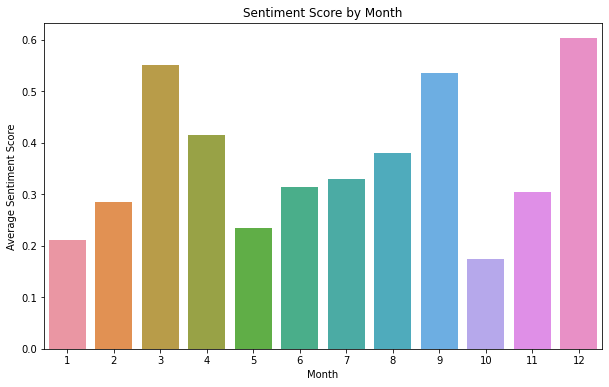

Out[91]: (None,)

In [ ]:
# Group by month and calculate the average sentiment score
monthly_sentiment_df = sentiment_trend_df.groupBy('review_month').avg('sentiment_score')

# Convert to Pandas DataFrame and sort by month
monthly_sentiment_pd = monthly_sentiment_df.toPandas().sort_values('review_month')

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='review_month', y='avg(sentiment_score)', data=monthly_sentiment_pd)
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment Score by Month')
plt.show(),

### 3. Recommendation system

#### Page rank algorithm :using graph-based algorithms for generating recommendations for new customers.

This approach involves developing a graph of items (products) and users, where the edges between nodes represent user-item interactions. By analyzing the graph structure, algorithm can identify clusters of similar items and users, and make recommendations based on these clusters.

In [ ]:
def create_product_review_graph(review_product_features_df):
    """
    Given a DataFrame containing product review data and features, create's a GraphFrame representing the product review graph.
    """
    # Convert the DataFrame to a GraphFrame
    vertices = review_product_features_df.selectExpr(
        "product_parent as id", 
        "average_rating as average_rating",
        "number_of_reviews as number_of_reviews"
    )
    edges = review_product_features_df.selectExpr(
        "customer_id as src", 
        "product_parent as dst"
    )
    g = GraphFrame(vertices, edges)

    return g


In [ ]:
def cluster_products_by_pagerank_and_features(product_features_df):
    """
    Clusters products based on their PageRank scores and features.
    Returns a DataFrame containing the product ID, cluster assignment, and PageRank score.
    """
    # Create a GraphFrame with the review data
    g = create_product_review_graph(product_features_df)
    
    print("Completed creating Graphframe\n")
    
    print("Running Page rank.........\n")
    # Calculating the PageRank of each product
    pr = g.pageRank(resetProbability=0.15, tol=0.01)
    
    print("Done !!!\n")

    # Joining the PageRank scores with the product features DataFrame
    product_clusters_df = pr.vertices.join(
        product_features_df.select('product_parent'),
        pr.vertices["id"] == product_features_df["product_parent"],
        how="inner"
    )
    
    print("Clustering pr scores and features to make recommendation\n")
    # Cluster the products based on their PageRank scores and features
    assembler = VectorAssembler(
        inputCols=["average_rating", "number_of_reviews", "pagerank"],
        outputCol="features"
    )
    product_clusters_df = assembler.transform(product_clusters_df)

    kmeans = KMeans(k=3, seed=1)
    model = kmeans.fit(product_clusters_df.select("features"))
    
    print("Model training done .....\n")
    
    print("Making Predictions........\n")
    predictions = model.transform(product_clusters_df)

    
    return predictions


###### Input to Page rank

In [ ]:
#constraint: limiting the dataframe, since pagerank cannot be computed on 300mb of data due to cluster size.
df_reviews_final_limited = df_reviews_final.limit(5000)

# Creating a DataFrame with review and product IDs
review_product_df = df_reviews_final_limited.select("customer_id", "product_parent").distinct()

# Creating a DataFrame with product features (e.g. rating, number of reviews, etc.)
product_features_df = df_reviews_final_limited.groupBy("product_parent").agg(
    F.avg("star_rating").alias("average_rating"),
    F.count("*").alias("number_of_reviews")
)
# Joining the two DataFrames to get a DataFrame with review and product features
review_product_features_df = review_product_df.join(
    product_features_df,
    "product_parent"
)

predictions = cluster_products_by_pagerank_and_features(review_product_features_df)

print("Done !!!")

# Select the relevant columns and return the result
results = predictions.select(
    F.col("id").alias("product_parent"),
    F.col("prediction").alias("cluster"),
    F.col("pagerank")
)

print("Evaluating the model ........")
# Evaluate the clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

print("Silhouette with squared euclidean distance = " + str(silhouette))


Completed creating Graphframe

Running Page rank.........

/databricks/spark/python/pyspark/sql/dataframe.py:129: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")
Done !!!

Clustering pr scores and features to make recommendation

Model training done .....

Making Predictions........

Done !!!
Evaluating the model ........
Silhouette with squared euclidean distance = 0.7916846604224284


Silhouette score ranges from -1 to 1, where a score of -1 indicates incorrect clustering, 0 indicates overlapping clusters and 1 indicates highly dense and well-separated clusters. Generally, a silhouette score of 0.7 or above is considered good for most practical purposes.

###### Products for Recommendations on Home page of new customers

In [ ]:
results = results.distinct()
sorted_nodes = results.sort('pagerank', ascending=False)
top_k_nodes = [row['product_parent'] for row in sorted_nodes.head(10)]
filtered_df = df_reviews_final.filter(F.col('product_parent').isin(top_k_nodes)).select('product_title').distinct()
display(filtered_df)

product_title
Casio Lrw200h-7bvcf Womens Dive Series Diver Look Analog Watch
SE JT6216 21-Piece Watch Repair Kit
Timex Men's Expedition Field Chronograph Watch
Casio Women's LRW-200H-2BVCF Stainless Steel Watch Resin Band
Invicta Men's 8928OB Pro Diver Gold Stainless Steel Two-Tone Automatic Watch
Motorola Moto 360 Modern Timepiece Smart Watch - Black Leather 00418NARTL
Bling Jewelry Plated Classic Round CZ Ladies Watch
Timex Weekender Slip Thru Black/Black Watch
Timex Unisex Weekender Analog Quartz Watch
"Casio Men's Black Resin Dive Watch, with Black Face and Bi-Directional Rotating Bezel, 100 Meters Water Resistant, Features Day/Date Display, and Long Battery Life"


#### NLP technique

Natural Language Processing (NLP) techniques can be used to analyze user reviews to extract insights about user preferences and behavior. This data is then used to train machine learning model for personalized recommendations.

In [ ]:

# Define a function to recommend products based on user's reviews
def recommend_products_using_nlp(user_reviews, tfidf,tfidf_matrix,num_recommendations=5):
    
    # Computing TF-IDF matrix for the user's review text
    user_tfidf_matrix = tfidf.transform([user_reviews])
    
    # Computing cosine similarity between the user's review and all reviews in the dataset
    user_cosine_sim = cosine_similarity(user_tfidf_matrix, tfidf_matrix)[0]
    
    # Sorting reviews by cosine similarity score in descending order
    review_indices = list(enumerate(user_cosine_sim))
    review_indices_sorted = sorted(review_indices, key=lambda x:x[1], reverse=True)
    
    # Get the indices of the top N most similar reviews
    top_review_indices = [i[0] for i in review_indices_sorted[:num_recommendations]]
    
    # Get the product IDs for the top N reviews
    top_product_ids = df_reviews.iloc[top_review_indices]['product_id'].tolist()
    
    # Get the product names for the top N reviews
    top_product_names = df_reviews.iloc[top_review_indices]['product_title'].tolist()
    
    # Return the top N product IDs and names as recommendations
    return {'product_ids': top_product_ids, 'product_names': top_product_names}


In [ ]:
# input to NLP, Limiting dataset to avoid memory issue
df_watches = df_watches_review_limited.limit(5000)
df_gift = df_gift_card_review.limit(5000)
df_personal_item = df_personal_care_review.limit(5000)
df_union_1 = df_watches.union(df_gift)
df_nlp = df_union_1.union(df_personal_item)

#
df_reviews = df_nlp.toPandas()

# Performing text preprocessing
df_reviews['review_body'] = df_reviews['review_body'].apply(lambda x: str(x).lower())  # convert to lowercase
df_reviews['review_body'] = df_reviews['review_body'].apply(lambda x: ' '.join(x.split()))  # remove extra whitespaces


###### Training TfidfVectorizer to perform collabrative filtering.

Collaborative Filtering: It is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). Using user-based collaborative filtering i.e., the rating of an item for a user based on the ratings of similar users,

In [ ]:
# Create a TF-IDF matrix for the review text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_reviews['review_body'])


###### Generating recommendations based on review's

In [ ]:
# Example usage1: recommend products based on user's reviews
user_reviews = "Invacare no longer makes a quad cane with a plastic base and 5 cane tips as shown in this picture (as I did, you can check their web site to be sure).  If you purchase this product you will be shipped a slightly heavier cane with a metal base and four legs/tips.      In my experience, the plastic based canes are less durable because they tend to break easily when very cold, but I nevertheless prefer them because they are lighted weight. The handle is also more comfortable than other quad canes."

print("user review:", user_reviews)
recommendations = recommend_products_using_nlp(user_reviews,tfidf,tfidf_matrix)
print("\nRecommended products:")
for i, product in enumerate(recommendations['product_names']):
    print(f"{i+1}. {product}")
    

user review: Invacare no longer makes a quad cane with a plastic base and 5 cane tips as shown in this picture (as I did, you can check their web site to be sure).  If you purchase this product you will be shipped a slightly heavier cane with a metal base and four legs/tips.      In my experience, the plastic based canes are less durable because they tend to break easily when very cold, but I nevertheless prefer them because they are lighted weight. The handle is also more comfortable than other quad canes.

Recommended products:
1. Body Back Company’s Body Back Buddy Trigger Point Therapy Self Massage Tool - PARENT
2. Lobob Soft Contact Insertion/Removal Kit
3. Readers Microvision W-Case 1.50
4. Plastic Braille Slate 28 Cell 4 Line
5. Body Back Company’s Body Back Buddy Trigger Point Therapy Self Massage Tool - PARENT


In [ ]:
# Example usage2: recommend products based on user's reviews
user_reviews = "I love this watch, daniel Wellington women's watch is the best watch for me"

print("user review:", user_reviews)
recommendations = recommend_products_using_nlp(user_reviews,tfidf,tfidf_matrix)
print("\nRecommended products:")
for i, product in enumerate(recommendations['product_names']):
    print(f"{i+1}. {product}")

user review: I love this watch, daniel Wellington women's watch is the best watch for me

Recommended products:
1. Casio F91W Digital Sports Watch
2. Bulova Men's 98A123 BVA-SERIES Two-Tone Stainless Steel Automatic Bracelet Watch
3. Fossil Women's ES3148 Georgia Three-Hand Gold-Tone Stainless Steel Watch with Leather Band
4. Fossil Women's ES3040 Stella Grey Aluminum and Stainless Steel Watch
5. Casio Men's MTP1244D-2A Silver Stainless-Steel Quartz Watch with Blue Dial


### Reference

1. Recommender Systems in E-Commerce https://dl.acm.org/doi/pdf/10.1145/336992.337035#:~:text=Recommender%20systems%20are%20used%20by,prediction%20for%20future%20buying%20behavior.

2. https://medium.com/federatedai/sentiment-analysis-in-e-commerce-e8a06a498a75

3. Aws public access dataset: 
    1. https://s3.amazonaws.com/amazon-reviews-pds/readme.html
    2. https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt